## Decision Tree: Branch Analyses

1. Reporting Year (Year 0 - baseline)
2. TTC Tree cover
3. Land Use
4. Strategy
5. Imagery or site accessibility

### General Notes
- inactive projects include: africorp-intl, divine-bamboo-group, germark, poel, s3d-niger (7 total in cohort 1)

### Decisions
- An "open" or "closed" designation was assigned at the project level based on the proportion of sites that fell the into open/closed category.
- Project names that did not align were dropped.
- ttc NA - sites without TTC % were dropped. This occurs due to missing TTC tiles, eventually we will have data. 
- Sites where planting occurs in 2025 were dropped. TODO: Check the other sites in the prj.
- What does imagery % represent and what is a workable threshold? Does it represent coverage for the polygon or wider AOI?
- plant_start - date that planting is started is available by site, so would have to aggregate for a project. Does it make sense to do the first date of planting?
- This analysis lays out what the decision trees would look like at year0, year3 and year6, but only performs the analysis for year0. In order to do the subsequent years, would need to include the date that TTC analysis was run and check that against the planting date to understand the temporal component for each project (ie was the canopy open at plant start).


**Notes on datasets**
- `target_sys` in ttc csv refers to the current land use (used for error calcs). This is not used.
- when merging ttc and ft_polys using 3 keys - project name, site name and polygon name - there are some duplicates. It seems all values are the same except the slope and aspect stats. Not using these columns for now so dropping.

**Next**
- priority 1: pull all inputs from TM API - ttc and features need the same project names
- distributed vs concentrated assignment
- drop projects with NaN target sys (blue-forest and wells for zoe) and print out decision.
- list potential branches to build (aspect, slope, etc.)

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import math

import sys
sys.path.append('../src/')
import image_availability as img
import clean_raw_data as clean
import decision_trees as tree

%load_ext autoreload
%autoreload 2

# PARAMS

In [37]:
imagery_dir = "../data/imagery_availability/cohort1/"         # Rhiannon saved as "../data/afr100_cohort1_imagery_availability/"
ttc_input = '../data/ttc_baseline_110624.csv'                 # these are the ttc statistics
new_poly_feats = "../data/all_projects_TM_081424"             # this contains new land cover & intervention type
old_poly_feats = '../data/features_polygon_071824.csv'        # original polygon feature information
canopy_threshold = 40                                         # threshold for identifying open vs closed canopy projects
cloud_thresh = 50                                             # threshold for identifying image quality
img_count = 1                                                 # threshold for identifying image availability

In [4]:
# feats = pd.read_csv('../data/features_polygon_100124.csv')
# feats.head()

In [5]:
#feats[(feats.target_sys == 'natural-forest')&(feats.practice == 'assisted-natural-regeneration')]

In [6]:
#feats[feats.project_name == 'wildlife action group']

In [40]:
feats.practice.value_counts()

practice
tree-planting                                                   3005
direct-seeding                                                    90
tree-planting, assisted-natural-regeneration                      18
assisted-natural-regeneration                                     13
direct-seeding, tree-planting, assisted-natural-regeneration      11
direct-seeding, tree-planting                                      5
assisted-natural-regeneration, tree-planting                       2
asisted-natural-regeneration, tree-planting                        1
direct-seeding, assisted-natural-regeneration, tree-planting       1
tree-planting, direct-seeding                                      1
Name: count, dtype: int64

In [37]:
feats.target_sys.value_counts()

target_sys
agroforest                  2982
natural-forest                59
Agroforest                    58
woodlot-or-plantation         52
riparian-area-or-wetland      15
silvopasture                   9
mangrove                       8
urban-forest                   5
Name: count, dtype: int64

In [38]:
feats.practice.value_counts()

practice
tree-planting                                                   3005
direct-seeding                                                    90
tree-planting, assisted-natural-regeneration                      18
assisted-natural-regeneration                                     13
direct-seeding, tree-planting, assisted-natural-regeneration      11
direct-seeding, tree-planting                                      5
assisted-natural-regeneration, tree-planting                       2
asisted-natural-regeneration, tree-planting                        1
direct-seeding, assisted-natural-regeneration, tree-planting       1
tree-planting, direct-seeding                                      1
Name: count, dtype: int64

In [27]:
feats = feats.rename(columns={'project_name': 'project',
                              'site_name' : 'sitename'})

In [28]:
ttc = clean.clean_ttc_csv(ttc_input, 40)
ttc.head()

Dropping 221 polygons with null TTC values.



,ttc,project,sitename,poly_name,canopy
0,84.0,aerobic-agroforestry,AGO OWU,AGO OWU01,closed
1,0.0,tree-adoption-uganda,AGU - Tree Adoption Uganda,Agu_02,open
2,8.0,tree-adoption-uganda,AGU - Tree Adoption Uganda,Agu_10,open
3,0.0,tree-adoption-uganda,AGU - Tree Adoption Uganda,Agu_04,open
4,0.0,tree-adoption-uganda,AGU - Tree Adoption Uganda,Agu_13,open


In [29]:
comb = pd.merge(feats, ttc, on=['project', 'sitename', 'poly_name'])

In [31]:
comb

,project,framework_key,sitename,poly_name,plantstart,plantend,practice,target_sys,status,version_name,is_active,source,deleted_at,geom,ttc,canopy


In [34]:
feats.project.value_counts()

project
Katanino Forest Landscape Restoration Project - WeForest                                                  469
AGRICULTURE AND FOREST LANDSCAPES RESTORATION PROJECT                                                     304
Green steps Restoration Project                                                                           231
Building resilient livelihoods through reforestation and agroforestry at Atewa Forest                     208
Scaling ecosystem restoration and livelihoods improvements for people and nature                          202
                                                                                                         ... 
Ol Mariko Restoration Project in Mau Forest, Kenya                                                          1
Torok River Rehabilitation Project, Phase II.                                                               1
REJUVENATING THE GREAT RIFT VALLEY LANSCAPES                                                                1
La

## TTC CHECK

In [17]:
print(pd.__version__)

2.2.2


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3189 entries, 0 to 3188
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   project_name   3189 non-null   object 
 1   framework_key  3189 non-null   object 
 2   site_name      3189 non-null   object 
 3   poly_name      3189 non-null   object 
 4   plantstart     3189 non-null   object 
 5   plantend       3095 non-null   object 
 6   practice       3147 non-null   object 
 7   target_sys     3188 non-null   object 
 8   status         3189 non-null   object 
 9   version_name   273 non-null    object 
 10  is_active      3189 non-null   int64  
 11  source         3186 non-null   object 
 12  deleted_at     0 non-null      float64
 13  geometry       3189 non-null   object 
 14  tree_cover     3179 non-null   float64
dtypes: float64(2), int64(1), object(12)
memory usage: 373.8+ KB


In [20]:
df = pd.read_csv(ttc_input)
nulls = df[df.tree_cover.isna()]
ttc = df.dropna(subset=['tree_cover'])
ttc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3179 entries, 0 to 3188
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   project_name   3179 non-null   object 
 1   framework_key  3179 non-null   object 
 2   site_name      3179 non-null   object 
 3   poly_name      3179 non-null   object 
 4   plantstart     3179 non-null   object 
 5   plantend       3085 non-null   object 
 6   practice       3137 non-null   object 
 7   target_sys     3178 non-null   object 
 8   status         3179 non-null   object 
 9   version_name   272 non-null    object 
 10  is_active      3179 non-null   int64  
 11  source         3176 non-null   object 
 12  deleted_at     0 non-null      float64
 13  geometry       3179 non-null   object 
 14  tree_cover     3179 non-null   float64
dtypes: float64(2), int64(1), object(12)
memory usage: 397.4+ KB


# Data Prep & Cleaning

In [57]:
ttc, feats = clean.clean_combine_inputs(ttc_input, old_poly_feats, new_poly_feats, canopy_threshold)

Dropping 10 rows with null TTC values.

Dropping 1158 duplicate polygon rows.

Dropping 9 rows with NaN target system.

10 target systems: ['silvopasture', 'urban-forest', 'mangrove', 'agroforest,silvopasture', 'agroforest,wetland', 'agroforest', 'wetland', 'wetland,plantation', 'plantation', 'natural-forest']

Cleaned input data saved at ../data/decision_tree_data_clean.csv


In [62]:
list(set(feats.project_name))

['env-coffee-forest-forum',
 'green-pot',
 'intl-tree-foundation',
 'lead-foundation',
 'mt-kenya-env-cons',
 'conservation-south-africa',
 'per-ja-t',
 'inst-oikos-onlus',
 'sahel-eco-mali',
 'ccao',
 'ecofix',
 'ncf',
 'asic',
 'ntisd',
 'aerobic-agroforestry',
 'ope',
 'scope',
 'mapto',
 'ileg',
 'soc-cons-nature-liberia',
 'sadhana-forest-kenya',
 'surudev',
 'shekina',
 'trees-for-the-future',
 'wildlife-action-group',
 'adhd',
 'dnrc',
 'edu-env-dev-durable',
 'hen-mpoano',
 'kijabe-forest-trust',
 'killimanjaro-project',
 'panr',
 'afrex-gold',
 'safire',
 'centre-valbio',
 'fap-ngo',
 'inec-ghana',
 'recor',
 'goshen-global-vision',
 'addax-gum',
 'blessed-action',
 'bccp',
 'ecotrust-uganda',
 'snrma',
 'my-trees-trust',
 'plant-with-purpose-burundi',
 'fairtree-kenya',
 'pado-investments',
 'eco-benin',
 'justdiggit',
 'kenvo',
 'ageref-cl',
 'kijani-forestry',
 'pades',
 'birdlife-intl',
 'solid-east-central-afr-zambia',
 'world-vision-intl-ethiopia',
 'fairtree-tanzania',


In [61]:
list(set(ttc.project_name))

['Restoration of Kiambu and Lari Landscapes through Planting and Growing Trees - KENVO',
 'Forest restoration for improved livelihoods and resilience to climate change, Nyandarua County, Kenya.',
 'Restoring Endao Catchment; A Community-Based Tree Growing Project',
 'Integrating Landscape Restoration and Community  Livelihoods in Nyamasheke District',
 'TAAP (Tropical Almond Agroforestry Project) in Ghana',
 'Forest Landscape Restoration and Lake Rumira Buffer Zone Restoration in Bugesera District, Eastern Province. - RECOR',
 'Restoration of Cherangani forest ecosystem services through direct planting of trees inside degraded state forests',
 'Afram Headwaters Restoration Initiative (AHRI)',
 'Cocoa Landscape Restoration through Dynamic Agroforestry',
 'Bahati Forest Conservation & Livelihood Improvement Project ( BACOLIP)',
 'Reforestation of degraded lands and riparian vegetation for improved climate resilience',
 'Restoration of Black Volta Basin Landscape for Energy, Income and En

In [59]:
feats

,project_name,site_name,poly_name,plantstart,target_sys_og,practice_og,Area_ha,baseline_img,ev_img,slope_stats,aspect_stats,target_sys,practice
0,addax-gum,Site de Plantation,Site de Plantation 1,2022-08-03,Null,Null,22.210348,0.0,2.0,"[{'min': 0.0, 'max': 11384.19921875, 'mean': 4...","[{'min': 0.0, 'max': 354.8055725097656, 'mean'...","agroforest,silvopasture","tree-planting,ANR"
1,adhd,Agomaza/Deme/Goudeve/Lomnava,ESSESSI KOSSI RAPHAEL,2023-03-10,agroforest,Null,1.077154,1.0,0.0,"[{'min': 1272.792236328125, 'max': 14843.18066...","[{'min': 0.0, 'max': 353.6598205566406, 'mean'...",agroforest,tree-planting
2,adhd,Agomaza/Deme/Goudeve/Lomnava,AMENKO VALAIRE,2023-03-10,agroforest,Null,1.077154,1.0,0.0,"[{'min': 1423.02490234375, 'max': 5437.3706054...","[{'min': 18.434947967529297, 'max': 348.690063...",agroforest,tree-planting
3,adhd,Agomaza/Deme/Goudeve/Lomnava,BODJOA KOMLAN,2023-03-10,agroforest,Null,1.077141,1.0,0.0,"[{'min': 1909.1883544921875, 'max': 12870.3144...","[{'min': 0.0, 'max': 348.6900634765625, 'mean'...",agroforest,tree-planting
4,adhd,Agomaza/Deme/Goudeve/Lomnava,BODJOA ETSE,2023-03-10,agroforest,Null,1.077145,1.0,0.0,"[{'min': 636.3961181640625, 'max': 15286.75878...","[{'min': 5.710593223571777, 'max': 351.8699035...",agroforest,tree-planting
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22830,world-vision-intl-ethiopia,Metsilet Restoration Site,Metsilet_01,2023-07-17,Null,tree-planting,203.390555,7.0,1.0,"[{'min': 1800.0, 'max': 97070.75, 'mean': 3997...","[{'min': 0.0, 'max': 359.5488586425781, 'mean'...",natural-forest,tree-planting
22831,world-vision-intl-ethiopia,Saki Restoration Site,Saki_01,2023-03-08,Null,tree-planting,9.176889,6.0,3.0,"[{'min': 6644.17041015625, 'max': 92382.710937...","[{'min': 2.4540317058563232, 'max': 348.690063...",natural-forest,tree-planting
22832,world-vision-intl-ethiopia,Tsafeter Restoration Site,Tsafeter_01,2023-07-17,Null,tree-planting,12.583937,7.0,1.0,"[{'min': 4633.03369140625, 'max': 81311.898437...","[{'min': 4.899092674255371, 'max': 272.7263183...",natural-forest,tree-planting
22833,world-vision-intl-ethiopia,Ankitag Restoration Site,Ankitag_01,2023-07-06,Null,tree-planting,385.644613,5.0,2.0,"[{'min': 636.3961181640625, 'max': 202597.9687...","[{'min': 0.0, 'max': 356.1859130859375, 'mean'...",agroforest,tree-planting


## Create Trees

In [56]:
tree = tree.year0(ttc_input,
          old_poly_feats,
          new_poly_feats,
          imagery_dir,
          canopy_threshold,
          cloud_thresh,
          img_count)

Running decision tree for Year 0: Baseline
------- DATA PREP ------- 

Preparing inputs according to params...
Dropping 10 rows with null TTC values.

Dropping 1158 duplicate polygon rows.

Dropping 9 rows with NaN target system.

10 target systems: ['silvopasture', 'urban-forest', 'mangrove', 'agroforest,silvopasture', 'agroforest,wetland', 'agroforest', 'wetland', 'wetland,plantation', 'plantation', 'natural-forest']

Cleaned input data saved at ../data/decision_tree_data_clean.csv


AttributeError: 'tuple' object has no attribute 'columns'

In [124]:
df.target_sys.value_counts()

target_sys
agroforest                 11664
natural-forest               203
plantation                    70
wetland                       50
silvopasture                  39
mangrove                      30
wetland,plantation            10
agroforest,wetland             8
agroforest,silvopasture        1
urban-forest                   1
Name: count, dtype: int64

In [126]:
base.shape

(8754, 16)

In [127]:
base

,project,sitename,poly_name,plantstart,target_sys_og,practice_og,area_ha,baseline_img,ev_img,slope_stats,aspect_stats,target_sys,practice,ttc,canopy,method
0,addax-gum,Site de Plantation,Site de Plantation 1,2022-08-03,Null,Null,22.210348,0.0,2.0,"[{'min': 0.0, 'max': 11384.19921875, 'mean': 4...","[{'min': 0.0, 'max': 354.8055725097656, 'mean'...","agroforest,silvopasture","tree-planting,ANR",0.0,open,field
1,adhd,Agomaza/Deme/Goudeve/Lomnava,ESSESSI KOSSI RAPHAEL,2023-03-10,agroforest,Null,1.077154,1.0,0.0,"[{'min': 1272.792236328125, 'max': 14843.18066...","[{'min': 0.0, 'max': 353.6598205566406, 'mean'...",agroforest,tree-planting,5.0,open,remote
2,adhd,Agomaza/Deme/Goudeve/Lomnava,AMENKO VALAIRE,2023-03-10,agroforest,Null,1.077154,1.0,0.0,"[{'min': 1423.02490234375, 'max': 5437.3706054...","[{'min': 18.434947967529297, 'max': 348.690063...",agroforest,tree-planting,12.0,open,remote
3,adhd,Agomaza/Deme/Goudeve/Lomnava,BODJOA KOMLAN,2023-03-10,agroforest,Null,1.077141,1.0,0.0,"[{'min': 1909.1883544921875, 'max': 12870.3144...","[{'min': 0.0, 'max': 348.6900634765625, 'mean'...",agroforest,tree-planting,19.0,open,remote
4,adhd,Agomaza/Deme/Goudeve/Lomnava,BODJOA ETSE,2023-03-10,agroforest,Null,1.077145,1.0,0.0,"[{'min': 636.3961181640625, 'max': 15286.75878...","[{'min': 5.710593223571777, 'max': 351.8699035...",agroforest,tree-planting,20.0,open,remote
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8749,world-vision-intl-ethiopia,Barset Terara Restoration Site,Barset Terera_01,2023-07-17,Null,tree-planting,85.842271,6.0,1.0,"[{'min': 900.0, 'max': 159385.140625, 'mean': ...","[{'min': 0.7638984322547913, 'max': 352.596282...",natural-forest,tree-planting,43.0,closed,field
8750,world-vision-intl-ethiopia,Dibet Terara Restoration Site,Dibet_01,2023-07-06,Null,tree-planting,13.590045,5.0,1.0,"[{'min': 9961.1748046875, 'max': 63957.015625,...","[{'min': 96.56269836425781, 'max': 262.5041503...",natural-forest,tree-planting,94.0,closed,field
8751,world-vision-intl-ethiopia,Gudebala Restoration Site,Gudebala_01,2023-07-17,Null,tree-planting,63.281253,4.0,1.0,"[{'min': 9545.94140625, 'max': 90726.0703125, ...","[{'min': 135.0, 'max': 315.0, 'mean': 207.8276...",natural-forest,tree-planting,11.0,closed,field
8752,world-vision-intl-ethiopia,Metsilet Restoration Site,Metsilet_01,2023-07-17,Null,tree-planting,203.390555,7.0,1.0,"[{'min': 1800.0, 'max': 97070.75, 'mean': 3997...","[{'min': 0.0, 'max': 359.5488586425781, 'mean'...",natural-forest,tree-planting,30.0,closed,field


# Issues / QAQC Needs

### Issue 1. Diff in count

In [84]:
# new shapefile has 38 fewer polygons
shp = gpd.read_file(new_poly_feats)
ft_poly = pd.read_csv(old_poly_feats)
display(shp.shape, ft_poly.shape)
display(shp.shape[0] - ft_poly.shape[0])

(13017, 7)

(13055, 11)

-38

In [85]:
# compare project, poly and site names across TM polygons
shp_prjlist = list(set(shp.Project))
ft_prjlist = list(set(ft_poly.Project))
shp_polylist = list(set(shp.poly_name))
ft_polylist = list(set(ft_poly.poly_name))
shp_sitelist = list(set(shp.SiteName))
ft_sitelist = list(set(ft_poly.SiteName))
diff_prj = [i for i in ft_prjlist if i not in shp_prjlist]
diff_poly = [i for i in ft_polylist if i not in shp_polylist]
diff_site = [i for i in ft_sitelist if i not in shp_sitelist]

print(diff_prj)
print(diff_poly)
print(diff_site)

['nguni']
['koko Regeneration site', 'Reforestation Project\xa010']
['Reforestation Project\xa0', 'Namwene', 'Main_Gate', 'Bbambula', 'Kikandwa', 'koko Regeneration site']


In [86]:
# how many polys within the missing sites?
site_df = ft_poly[ft_poly.SiteName.isin(['Bbambula',
                              'Reforestation Project\xa0',
                              'Main_Gate',
                              'koko Regeneration site',
                              'Namwene',
                              'Kikandwa'])]
site_df.shape

(54, 11)

### Issue 2. Duplicate polygons
Some polygons are almost exactly the same except for the slope and aspect statistics. Were two methods applied to calculate these stats? Which one to drop?

### Issue 3. TTC is null for some polygons
221 polygons have null values for TTC, these are dropped from the analysis.

# Check Results

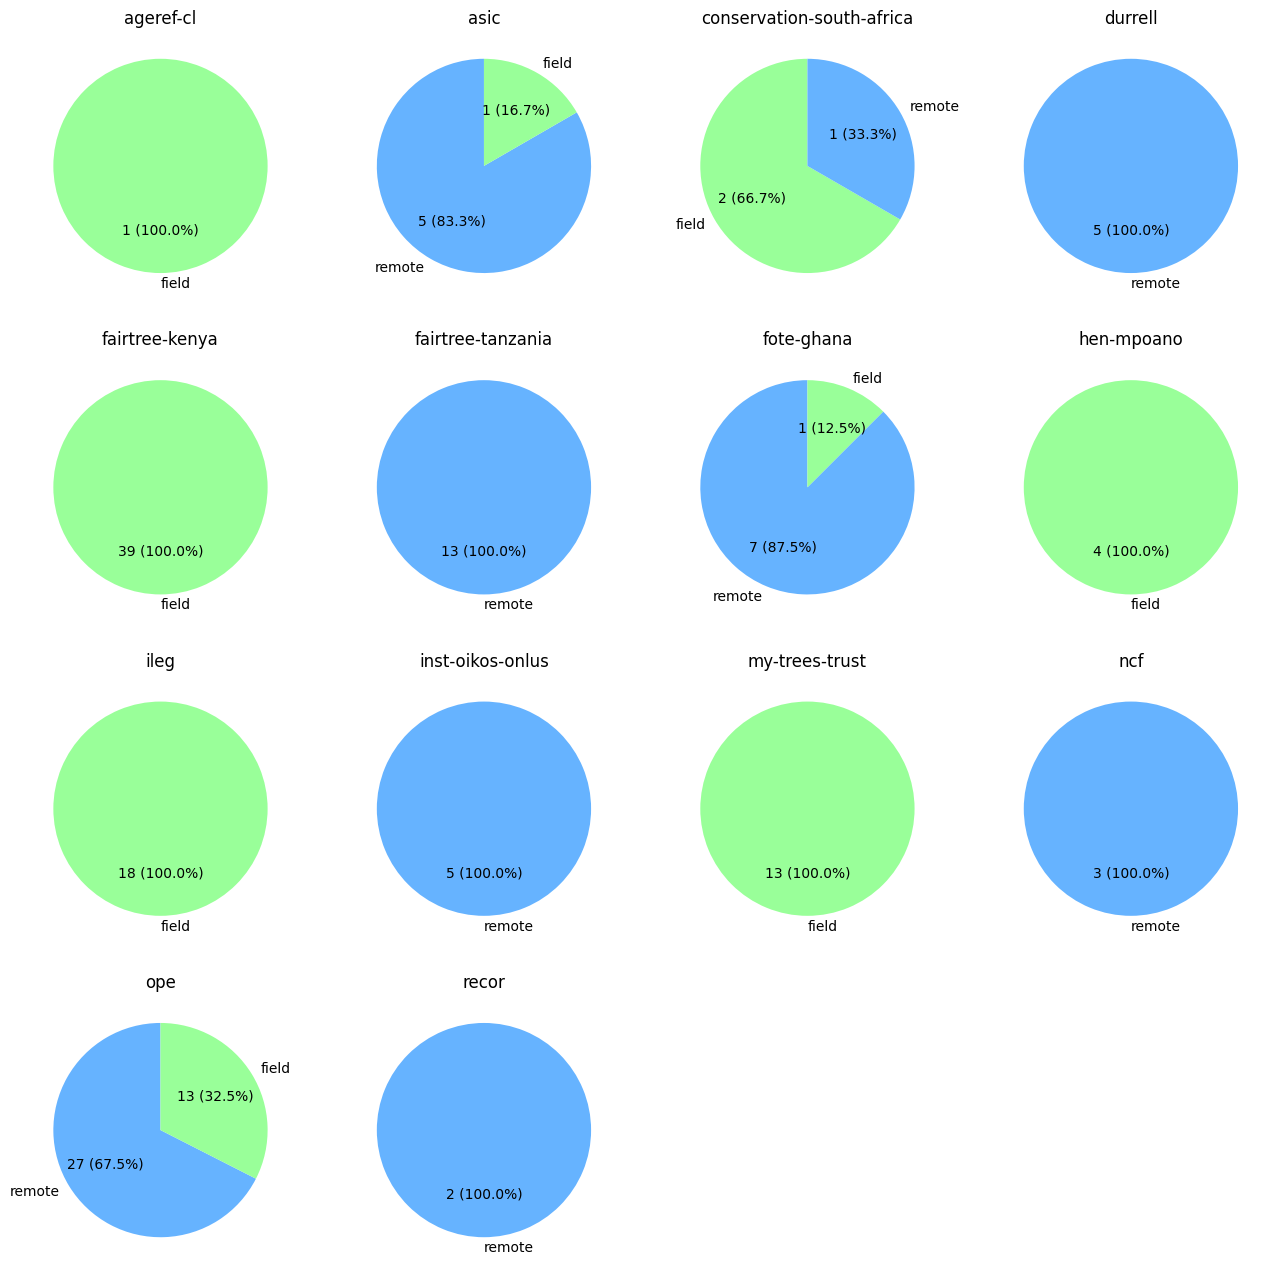

# Legacy

In [ ]:
    # ## BRANCH 2 ##
    # # not represented: wetland,plantation / urban-forest
    # open_landcovers = ['agroforest', 
    #                    'mangrove', 
    #                    'wetland', 
    #                    'silvopasture', 
    #                    'plantation', 
    #                    'natural-forest', 
    #                    'agroforest,silvopasture',
    #                    'agroforest,wetland',
    #                    ]
    # closed_landcovers = ['plantation', 
    #                      'natural-forest',
    #                      'urban-forest'
    #                      ]
    # open_sys = open_[open_.target_sys.isin(open_landcovers)]
    # closed_sys = closed_[closed_.target_sys.isin(closed_landcovers)]

In [ ]:
    af_tp = open_[(open_.target_sys == 'agroforestry') & (open_.practice == 'tree-planting')]
    af_ds = open_[(open_.target_sys == 'agroforestry') & (open_.practice == 'direct-seeding')]
    af_anr = open_[(open_.target_sys == 'agroforestry') & (open_.practice == 'ANR')]
    mgr_tp = open_[(open_.target_sys == 'mangrove') & (open_.practice == 'tree-planting')]
    mgr_anr = open_[(open_.target_sys == 'mangrove') & (open_.practice == 'ANR')]
    nf_tp = open_[(open_.target_sys == 'natural forest') & (open_.practice == 'tree-planting')]
    nf_ds = open_[(open_.target_sys == 'natural forest') & (open_.practice == 'direct-seeding')]
    nf_anr = open_[(open_.target_sys == 'natural forest') & (open_.practice == 'ANR')]
    plant_tp = open_[(open_.target_sys == 'plantation') & (open_.practice == 'tree-planting')]
    wet_tp = open_[(open_.target_sys == 'wetland') & (open_.practice == 'tree-planting')]
    wet_anr = open_[(open_.target_sys == 'wetland') & (open_.practice == 'ANR')]
    silvo_tp a=  & (open_.practice == 'tree-planting')]
    silvo_ds = open_[(open_.target_sys == 'silvopasture') & (open_.practice == 'direct-seeding')]
    silvo_anr = open_[(open_.target_sys == 'silvopasture') & (open_.practice == 'ANR')]
    plant_tp_closed = closed_[(closed_.target_sys == 'plantation') & (closed_.practice == 'tree-planting')]
    nf_tp_closed =  & (closed_.practice == 'tree-planting')]
    nf_ds_closed = closed_[(closed_.target_sys == 'natural forest') & (closed_.practice == 'direct-seeding')]
    nf_anr_closed = closed_[(closed_.target_sys == 'natural forest') & (closed_.practice == 'ANR')]

    af = open_[(open_.target_sys == 'agroforestry')]
    mgr = open_[(open_.target_sys == 'mangrove')]
    wet = open_[(open_.target_sys == 'wetland')]
    silvo = open_[(open_.target_sys == 'silvopasture')]
    plant_open = open_[(open_.target_sys == 'plantation')]
    nf_open = open_[(open_.target_sys == 'natural forest')]
    plant_closed = closed_[(closed_.target_sys == 'plantation')]
    nf_closed = closed_[(closed_.target_sys == 'natural forest')]

In [77]:
img_dir = '../data/imagery_availability/cohort1/'
imagery_files = os.listdir(img_dir)
imagery = []
for project in imagery_files:
    df = pd.read_csv(f"{img_dir}/{project}")
    sub_df = df[['Name', 
                 'properties.datetime',
                 'collection', 
                 'properties.eo:cloud_cover', 
                 'properties.off_nadir_avg']]
    sub_df = sub_df.assign(Project=project.replace('afr100_', '').replace('_imagery_availability.csv', ''))
    imagery.append(sub_df)
all_projects_df = pd.concat(imagery).reset_index()
all_projects_df = all_projects_df[['Project', 
                                   'Name', 
                                   'properties.datetime',
                                   'collection', 
                                   'properties.eo:cloud_cover',
                                   'properties.off_nadir_avg']]
all_projects_df = all_projects_df[~pd.isna(all_projects_df['Name'])]
all_projects_df.rename(columns={'Name':'poly_name'}, inplace=True)
all_projects_df.loc[:, 'properties.datetime'] = pd.to_datetime(all_projects_df['properties.datetime'], 
                                                               format='mixed').dt.normalize()
all_projects_df.loc[:, 'properties.datetime'] = all_projects_df['properties.datetime'].apply(lambda x: x.replace(tzinfo=None))

/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_59671/842933163.py:5: DtypeWarning: Columns (73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{img_dir}/{project}")


In [78]:
all_projects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147348 entries, 0 to 147347
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Project                    147348 non-null  object 
 1   poly_name                  147348 non-null  object 
 2   properties.datetime        147348 non-null  object 
 3   collection                 147348 non-null  object 
 4   properties.eo:cloud_cover  147348 non-null  float64
 5   properties.off_nadir_avg   147348 non-null  float64
dtypes: float64(2), object(4)
memory usage: 6.7+ MB


In [85]:
# create a master csv of all projects for img availability, elevation and sun
img_dir = 'imagery_availability/cohort1/'
csv_list = listdir(img_dir)
csv_list = [re.split(r'_', file)[1] for file in csv_list if file.endswith('.csv')]
master_csv = pd.DataFrame()
for i in csv_list[0:1]:
    i = 'bccp'
    df = pd.read_csv(f'{img_dir}afr100_{i}_imagery_availability.csv')
    df = df[['id', 
             'collection', 
             'properties.datetime',
             'properties.eo:cloud_cover',
             'properties.collect_time_end',
             'properties.collect_time_start',
#              'properties.off_nadir_avg', 
#              'properties.off_nadir_end',
#              'properties.off_nadir_max', 
#              'properties.off_nadir_min',
#              'properties.view:sun_elevation_max',
#              'properties.view:sun_elevation_min',
            ]]
    dt_cols = ['properties.datetime',
                 'properties.collect_time_end',
                 'properties.collect_time_start',
               ]
    df[dt_cols] = df[dt_cols].apply(pd.to_datetime, errors='coerce')
    # Ensure 'properties.datetime' column is timezone-naive
    df['properties.datetime'] = df['properties.datetime'].apply(lambda x: x.replace(tzinfo=None) if x.tzinfo else x)
    planting_date = ttc[ttc.project == i]['plantstart']
#    df['baseline_imgs'] = df['properties.datetime'].apply(lambda x: 1 if planting_date <= x <= planting_date + timedelta(days=365) else 0)
#     df['baseline_cloud_free'] = len(df[(df['baseline_imgs'] == 1) & (df['properties.eo:cloud_cover'] == 1)])
#     agg_data = {
#         'project_name': i,
#         'total_imgs': len(df),
#         'total_cloud_free': sum(df['properties.eo:cloud_cover']),
#         'baseline_imgs': sum(df['baseline_imgs']),
#         'baseline_cloud_free':sum(df['baseline_cloud_free']),
#                              }
# #         'early_imgs':,
# #         'early_cloud_free',
# #         'endline_imgs':,
# #         'endline_cloud_free':,
#     agg_table = pd.DataFrame([agg_data])
    

In [15]:
ft_raw.columns = ft_raw.columns.map(lambda x: re.sub(' ', '_', x.lower().strip()))
ft = ft_raw[['project', 'area_ha', 'percent_imagery_coverage', 'agroforestry',
       'tree_planting', 'assisted_natural_regeneration', 'enrichment_planting',
       'reforestation', 'direct_propagules_planting', 'natural_regeneration',
       'applied_nucleation/tree_island', 'woodlot', 'direct_seeding',
       'mangrove_tree_restoration', 'natural_forest', 'riparian_restoration']]
ft = ft.rename(columns={'mangrove_tree_restoration': 'mangrove',
                    'riparian_restoration':'riparian'})

## land use
land_use = ['agroforestry',
            'woodlot',
            'mangrove', 
            'natural_forest', 
            'riparian']

for col in land_use:
    ft[col] = ft[col].apply(lambda x: 1 if x > 0 else x)

## planting strategy
strategy = ['direct_seeding', 
            'tree_planting', 
            'assisted_natural_regeneration', 
            'natural_regeneration', # change this
            'enrichment_planting',
            'direct_propagules_planting',
            'applied_nucleation/tree_island',
            'reforestation',
           ]

for col in strategy:
    ft[col] = ft[col].apply(lambda x: 1 if x > 0 else x)